# Determining the tariff for a telecom company
The mobile operator "Megaline" found out that many customers use archival tariffs. They want to build a system that can analyze customer behavior and offer users a new tariff: "Smart" or "Ultra".

At your disposal is data on the behavior of customers who have already switched to these tariffs. You need to build a model for the classification problem that will select the appropriate rate. Data preprocessing is not required - you have already done it.

Build the model with the highest possible accuracy. To pass the project successfully, you need to bring the percentage of correct answers to at least 0.75. Check accuracy on the test set yourself.

- Divide the input data into training, validation and test sets.
- Explore the quality of different models by changing hyperparameters. Briefly write the conclusions of the study.
- Check the quality of the model on the test set.

Each object in the data set is information about the behavior of one user per month. Known:
- calls — number of calls,
- minutes — total duration of calls in minutes,
- messages — number of sms messages,
- mb_used - used Internet traffic in Mb,
- is_ultra - what tariff did you use during the month ("Ultra" - 1, "Smart" - 0).


## Exploring general information

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats as st
from scipy.stats import norm
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
path ='/Users/vzuga/Documents/jupyter/'

try:
    calls = pd.read_csv('calls.csv')
    internet = pd.read_csv('internet.csv')
    messages = pd.read_csv('messages.csv')
    tariffs = pd.read_csv('tariffs.csv')
    users = pd.read_csv('users.csv')
except:
    calls = pd.read_csv(path+'/datasets/calls.csv')
    internet = pd.read_csv(path+'/datasets/internet.csv')
    messages = pd.read_csv(path+'/datasets/messages.csv')
    tariffs = pd.read_csv(path+'/datasets/tariffs.csv')
    users = pd.read_csv(path+'/datasets/users.csv')

### calls

In [3]:
calls.info()
print()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB



,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.describe()

,duration,user_id
count,202607.00,202607.00
mean,6.76,1253.94
std,5.84,144.72
min,0.00,1000.00
25%,1.30,1126.00
50%,6.00,1260.00
75%,10.70,1379.00
max,38.00,1499.00


In [5]:
calls.duplicated().sum()

0

Conclusions:
* there are no gaps and duplicates in calls
* there are no abnormal values in the duration of calls
* call_date must be converted to DateTime
* duration round up and convert to int

### internet

In [6]:
internet.info()
print()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB



,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [7]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.00,149396.00,149396.00
mean,74697.50,370.19,1252.10
std,43127.05,278.30,144.05
min,0.00,0.00,1000.00
25%,37348.75,138.19,1130.00
50%,74697.50,348.01,1251.00
75%,112046.25,559.55,1380.00
max,149395.00,1724.83,1499.00


In [8]:
internet.duplicated().sum()

0

Conclusions:
* there are no gaps and duplicates in Internet sessions
* there are no abnormal values in the number of megabytes
* session_date must be converted to DateTime
* mb_used will need to be totaled for each month, converted to GB and rounded up and then converted to int.

### messages

In [9]:
messages.info()
print()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB



,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [10]:
messages.duplicated().sum()

0

Conclusions:
* there are no gaps and duplicates in the messages
* message_date must be converted to DateTime

### tariffs

In [11]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Description of tariffs.

### users

In [12]:
users.info()
print()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB



,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Based on the tasks in this file, I need information about user_id, city and tariffs. I'll check those columns.

In [13]:
users['user_id'].tail()

495    1495
496    1496
497    1497
498    1498
499    1499
Name: user_id, dtype: int64

user_id matches the indexes and is not repeated, but just in case, I will check for duplicates.

In [14]:
users.duplicated().sum()

0

In [15]:
users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

The cities are fine.

In [16]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

2/3 of users use the smart tariff.

Conclusions:
* no additional conversions are needed in users yet.

## Data preparation

### Preparing data (replacing types, errors, filling in gaps, etc.)

I'll round up the calls.

In [17]:
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)
calls['duration']

0          0
1          0
2          3
3         14
4          6
          ..
202602     1
202603    19
202604    11
202605     5
202606    20
Name: duration, Length: 202607, dtype: int64

I will convert the dates to DateTime and get the month and year from there (check that it is 2018 everywhere and there are no errors in the selection).

In [18]:
calls['call_date'].head(1)

0    2018-07-25
Name: call_date, dtype: object

In [19]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['month'] = pd.DatetimeIndex(calls['call_date']).month_name()
calls['year'] = pd.DatetimeIndex(calls['call_date']).year
calls['year'].unique()

array([2018])

In [20]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = pd.DatetimeIndex(internet['session_date']).month_name()
internet['year'] = pd.DatetimeIndex(internet['session_date']).year
internet['year'].unique()

array([2018])

In [21]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = pd.DatetimeIndex(messages['message_date']).month_name()
messages['year'] = pd.DatetimeIndex(messages['message_date']).year
messages['year'].unique()

array([2018])

In [22]:
messages['month'].value_counts()

December     20555
November     18244
October      17114
September    14759
August       13088
July         11320
June          8983
May           7298
April         5179
March         3648
February      1924
January        924
Name: month, dtype: int64

I got the months and checked: there are 12 of them and the year for all data is really 2018. But the number of months is not the same, which means that for each specific user the data may not be for the whole year.

### Preparing user data (calls, sms, traffic volume, etc.)

In [23]:
# sum up calls for the month
calls_sum = calls.groupby(['user_id', 'month'])['duration'].agg('sum').reset_index()
calls_sum.head()

,user_id,month,duration
0,1000,August,408
1,1000,December,333
2,1000,July,340
3,1000,June,172
4,1000,May,159


In [24]:
# calculate monthly traffic and round up to GB
internet_sum = internet.groupby(['user_id', 'month'])['mb_used'].agg('sum').reset_index()
internet_sum['gb_used'] = (internet_sum['mb_used']/1024).apply(np.ceil).astype(int)
internet_sum.head()

,user_id,month,mb_used,gb_used
0,1000,August,14055.93,14
1,1000,December,9817.61,10
2,1000,July,14003.64,14
3,1000,June,23233.77,23
4,1000,May,2253.49,3


In [25]:
# messages per month
messages_sum = messages.groupby(['user_id', 'month'])['id'].agg('count').reset_index()
messages_sum.columns = ['user_id', 'month', 'message_count'] #переименую колонку с кол-вом сообщений, чтобы не запутаться
messages_sum.head()

,user_id,month,message_count
0,1000,August,81
1,1000,December,70
2,1000,July,75
3,1000,June,60
4,1000,May,22


I will combine everything into one file, first I will connect calls, messages and traffic with the outer parameter (in case some months are missing somewhere), and then I will attach this to users.

In [26]:
df = users.merge((calls_sum.merge(messages_sum, how='outer')).merge(internet_sum, how='outer'), how='left', on='user_id')
df

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,duration,message_count,mb_used,gb_used
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,August,408.00,81.00,14055.93,14.00
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,December,333.00,70.00,9817.61,10.00
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,July,340.00,75.00,14003.64,14.00
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,June,172.00,60.00,23233.77,23.00
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,May,159.00,22.00,2253.49,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,September,471.00,44.00,22134.41,22.00
3212,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,December,492.00,66.00,13055.58,13.00
3213,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,November,612.00,59.00,17963.31,18.00
3214,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,October,449.00,48.00,17788.51,18.00


In [27]:
df = df.drop(columns=['age', 'churn_date', 'first_name', 'last_name', 'reg_date', 'mb_used'])

In [28]:
df.head()

,user_id,city,tariff,month,duration,message_count,gb_used
0,1000,Краснодар,ultra,August,408.00,81.00,14.00
1,1000,Краснодар,ultra,December,333.00,70.00,10.00
2,1000,Краснодар,ultra,July,340.00,75.00,14.00
3,1000,Краснодар,ultra,June,172.00,60.00,23.00
4,1000,Краснодар,ultra,May,159.00,22.00,3.00


It can be seen that the duration of calls, the number of messages and traffic became floats again, since as a result of the union there were missing values in some months, and pandas stores NaN columns only in floats. I will replace NaN with 0 so that there are no problems when calculating revenue and translate it into integers.

In [29]:
df.isna().mean()

user_id         0.00
city            0.00
tariff          0.00
month           0.00
duration        0.01
message_count   0.16
gb_used         0.00
dtype: float64

In [30]:
df = df.fillna(0)

In [31]:
df.isna().mean()

user_id         0.00
city            0.00
tariff          0.00
month           0.00
duration        0.00
message_count   0.00
gb_used         0.00
dtype: float64

In [32]:
df[['duration','message_count','gb_used']] = df[['duration','message_count','gb_used']].astype(int)

I'll calculate the income. I will write a function for this.

In [33]:
tariffs = tariffs.set_index('tariff_name')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
tariff_name,,,,,,,
smart,50,15360,500,550,200,3,3
ultra,1000,30720,3000,1950,150,1,1


In [34]:
tariffs.loc['smart', 'rub_monthly_fee']

550

In [35]:
def revenue(row):
    
    #calculation for smart tariff
    if row['tariff']=='smart':
        
        #price
        monthly_fee = tariffs.loc['smart', 'rub_monthly_fee']
        min_price = tariffs.loc['smart', 'rub_per_minute']
        mess_price = tariffs.loc['smart', 'rub_per_message']
        gb_price = tariffs.loc['smart', 'rub_per_gb']
        
        #minutes
        if row['duration'] <= 500:
            minutes = 0
        else:
            minutes = row['duration'] - 500
        
        #messages   
        if row['message_count'] <= 50:
            messages = 0
        else:
            messages = row['message_count'] - 50
        
        #gigabytes 
        if row['gb_used'] <= 15:
            gb = 0 
        else:
            gb = row['gb_used'] - 15
    
    #calculation for ultra tariff
    else:
        
        #price
        monthly_fee = tariffs.loc['ultra', 'rub_monthly_fee']
        min_price = tariffs.loc['ultra', 'rub_per_minute']
        mess_price = tariffs.loc['ultra', 'rub_per_message']
        gb_price = tariffs.loc['ultra', 'rub_per_gb']
        
        #minutes
        if row['duration'] <= 3000:
            minutes = 0
        else:
            minutes = row['duration'] - 3000
        
        #messages
        if row['message_count'] <= 1000:
            messages = 0
        else:
            messages = row['message_count'] - 1000
        
        #gigabytes
        if row['gb_used'] <= 30:
            gb = 0 
        else:
            gb = row['gb_used'] - 30
    
    #revenue
    rev = monthly_fee + minutes*min_price + messages*mess_price + gb*gb_price
    return rev

In [36]:
#check the function
print(df.loc[9])
print()
print('Выручка:', revenue(df.loc[9]))

#smart
#minutes up to 500, no messages, gigabytes 15+3, revenue = 550 + 3*200

user_id              1001
city               Москва
tariff              smart
month            November
duration              430
message_count           0
gb_used                18
Name: 9, dtype: object

Выручка: 1150


In [37]:
#check the function
print(df.loc[3])
print()
print('Выручка:', revenue(df.loc[3]))
#ультра

user_id               1000
city             Краснодар
tariff               ultra
month                 June
duration               172
message_count           60
gb_used                 23
Name: 3, dtype: object

Выручка: 1950


In [38]:
#I will calculate the revenue for all df
df['revenue'] = df.apply(revenue, axis=1)
df.head()

,user_id,city,tariff,month,duration,message_count,gb_used,revenue
0,1000,Краснодар,ultra,August,408,81,14,1950
1,1000,Краснодар,ultra,December,333,70,10,1950
2,1000,Краснодар,ultra,July,340,75,14,1950
3,1000,Краснодар,ultra,June,172,60,23,1950
4,1000,Краснодар,ultra,May,159,22,3,1950


## Data analysis and description

*Analyze the data. Describe the behavior of the operator's customers based on the sample. How many minutes of conversation, how many messages and how much Internet traffic do users of each tariff need per month? Calculate the mean, variance and standard deviation. Plot histograms. Describe the distributions.*

In [39]:
df_smart = df.query('tariff=="smart"')
df_ultra = df.query('tariff=="ultra"')

### Tariff Smart

I will build histograms and a normal distribution, I will designate the limits in the tariff with a vertical dotted line on the graphs.

#### Minutes

In [61]:
print('Mean:',df_smart['duration'].mean())
print('Variance:',np.var(df_smart['duration']))
print('Standard deviation',np.std(df_smart['duration']))

Mean: 417.747533632287
Variance: 36265.124153109864
Standard deviation 190.43404147659595


In [41]:
df.groupby('tariff')['duration'].agg(
    mean=(np.mean), var=(lambda x: np.var(x, ddof=0)), std=(lambda x: np.std(x, ddof=0)))

,mean,var,std
tariff,,,
smart,417.75,36265.12,190.43
ultra,526.09,100950.01,317.73


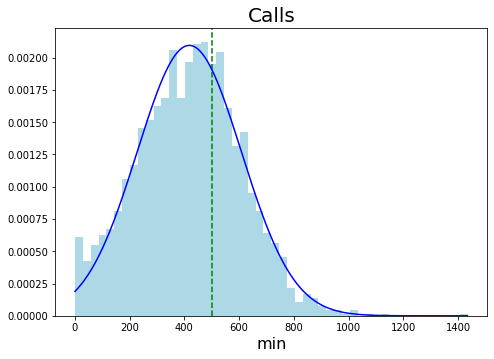

In [42]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
value = df_smart['duration']
ax.hist(value, color='lightblue', density=True, bins=50)
plt.axvline(x=500, color='green', linestyle='--') #tariff limit
x=range(0, value.max())
plt.plot(x, scipy.stats.norm.pdf(x, value.mean(), np.std(value)), color='blue')
plt.xlabel('min', fontsize=16)
plt.title('Calls', fontsize=20)
plt.show()

#### Messages

In [62]:
print('Mean:',df_smart['message_count'].mean())
print('Variance:',np.var(df_smart['message_count']))
print('Standart deviation',np.std(df_smart['message_count']))

Mean: 33.36905829596412
Variance: 796.597876691669
Standart deviation 28.224065559229217


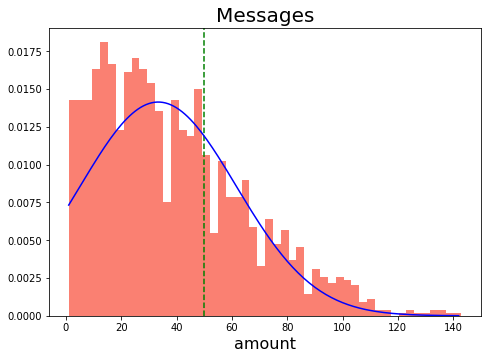

In [44]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
value = df_smart['message_count']
ax.hist(value, color='salmon', density=True, bins=50, range=(1,value.max()))
#the messages had the most gaps / zeros, I threw out zero values
plt.axvline(x=50, color='green', linestyle='--') #tariff limit
x=range(1, value.max())
plt.plot(x, scipy.stats.norm.pdf(x, value.mean(), np.std(value)), color='blue')
plt.xlabel('amount', fontsize=16)
plt.title('Messages', fontsize=20)
plt.show()

#### Internet traffic

In [63]:
print('Mean:',df_smart['gb_used'].mean())
print('Variance:',np.var(df_smart['gb_used']))
print('Standart deviation',np.std(df_smart['gb_used']))

Mean: 16.32152466367713
Variance: 33.11859498481772
Standart deviation 5.754875757548352


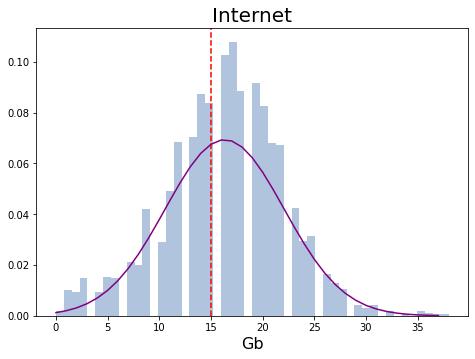

In [46]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
value = df_smart['gb_used']
ax.hist(value, color='lightsteelblue', density=True, bins=50)
plt.axvline(x=15, color='red', linestyle='--') #tariff limit
x=range(0, value.max())
plt.plot(x, scipy.stats.norm.pdf(x, value.mean(), np.std(value)), color='purple')
plt.xlabel('Gb', fontsize=16)
plt.title('Internet', fontsize=20)
plt.show()

#### Conclusions:
* average minutes: 418±190, messages: 33±28, traffic GB: 16±6
* slightly more than half of users fit into the limits on calls
* most of the users are within the message limits
* slightly less than half of users have enough traffic per month
* Calls and traffic are distributed normally, messages are shifted to the left with a large dispersion.

### Tariff Ultra

#### Minutes

In [64]:
print('Mean:',df_ultra['duration'].mean())
print('Variance:',np.var(df_ultra['duration']))
print('Standart deviation',np.std(df_ultra['duration']))

Mean: 526.0892494929006
Variance: 100950.00623331098
Standart deviation 317.7263071155912


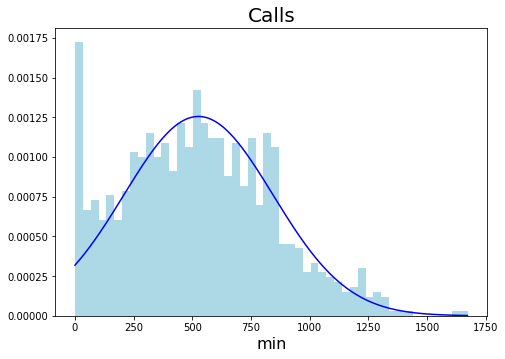

In [66]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
value = df_ultra['duration']
ax.hist(value, color='lightblue', density=True, bins=50)
#plt.axvline(x=3000, color='green', linestyle='--') #tariff limit
x=range(0, value.max())
plt.plot(x, scipy.stats.norm.pdf(x, value.mean(), np.std(value)), color='blue')
plt.xlabel('min', fontsize=16)
plt.title('Calls', fontsize=20)
plt.show()

#### Messages

In [67]:
print('Mean:',df_ultra['message_count'].mean())
print('Variance:',np.var(df_ultra['message_count']))
print('Standart deviation',np.std(df_ultra['message_count']))

Mean: 49.31338742393509
Variance: 2283.0995570851965
Standart deviation 47.781791061922284


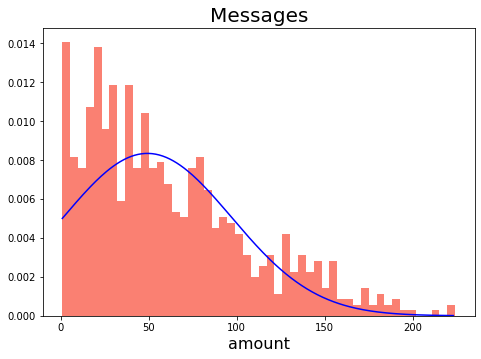

In [50]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
value = df_ultra['message_count']
ax.hist(value, color='salmon', density=True, bins=50, range=(1,value.max()))
#plt.axvline(x=1000, color='green', linestyle='--') #лимит тарифа
x=range(1, value.max())
plt.plot(x, scipy.stats.norm.pdf(x, value.mean(), np.std(value)), color='blue')
plt.xlabel('amount', fontsize=16)
plt.title('Messages', fontsize=20)
plt.show()

#### Internet traffic

In [68]:
print('Mean:',df_ultra['gb_used'].mean())
print('Variance:',np.var(df_ultra['gb_used']))
print('Standdart deviation',np.std(df_ultra['gb_used']))

Mean: 19.474645030425965
Variance: 97.27978308900674
Standdart deviation 9.863051408616236


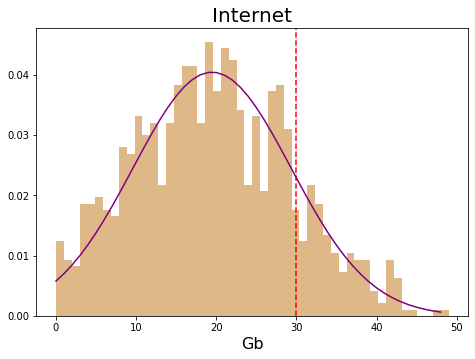

In [52]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
value = df_ultra['gb_used']
ax.hist(value, color='burlywood', density=True, bins=50)
plt.axvline(x=30, color='red', linestyle='--') #tariff limit
x=range(0, value.max())
plt.plot(x, scipy.stats.norm.pdf(x, value.mean(), np.std(value)), color='purple')
plt.xlabel('Gb', fontsize=16)
plt.title('Internet', fontsize=20)
plt.show()

#### Conclusions:
* average minutes: 526±318, messages: 49±48, traffic GB: 19±10
*Ultra tariff users do not exceed the limit on calls and messages
* but only 2/3 users will have enough traffic
* calls and traffic are distributed normally, messages are shifted to the left.

## Hypothesis testing and clarification

*Check hypotheses
the average revenue of users of the "Ultra" and "Smart" tariffs differ;
the average revenue of users from Moscow differs from the revenue of users from other regions.
Set the threshold value alpha yourself.
Explain:
How did you formulate the null and alternative hypotheses?
what criterion was used to test the hypotheses and why.*

### Revenue of different tariffs

In [69]:
print(f"Average Smart tariff revenue: {df_smart['revenue'].mean():.0f} ± {np.std(df_smart['revenue']):.0f}")
print(f"Average Ultra tariff revenue: {df_ultra['revenue'].mean():.0f} ± {np.std(df_ultra['revenue']):.0f}")

Average Smart tariff revenue: 1290 ± 818
Average Ultra tariff revenue: 2070 ± 376


array([<AxesSubplot:title={'center':'revenue'}>], dtype=object)

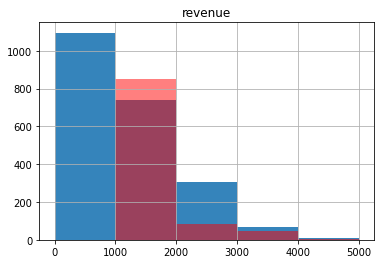

In [54]:
fig, ax = plt.subplots()
df_smart.hist(column=['revenue'], ax=ax, alpha=0.9, range=(0,5000), bins=5)
df_ultra.hist(column=['revenue'], ax=ax, color='red', alpha=0.5, range=(0,5000), bins=5)

The average revenue of the Ultra tariff is higher. I'll do a statistical test.

I will formulate hypotheses.

Null hypothesis: the revenues of both tariffs are the same. An alternative one-sided hypothesis: the revenue of the Ultra tariff is greater than the average revenue of the Smart tariff.

In [70]:
#Null hypothesis

alpha = .05 # level of significance

# if p-value is less than it, we reject the hypothesis
# I will add the equal_var parameter. I already know that the dispersion is different 
# and the number of users of the smart tariff is almost 2 times more

results = st.ttest_ind(df_smart['revenue'], df_ultra['revenue'], equal_var = False)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value:  1.927011394420941e-250
Rejecting the null hypothesis


In [76]:
#alternative hypothesis

interested_value =  2001 #df_smart['revenue'].mean()

# imagine that I did not just calculate the average for smart,
# but found some sample mean and it is slightly different from the true mean

alpha = 0.05
re = df_ultra['revenue']
results = st.ttest_1samp(df_ultra['revenue'], interested_value)

print('p-value:', results.pvalue/2)

if (results.pvalue/2 < alpha) and (df_ultra['revenue'].mean() > interested_value):
    print("Failed to reject the alternative hypothesis: \
the revenue is greater than the average revenue of the Smart tariff")

else:
    print("Rejecting the alternative hypothesis")

p-value: 5.470571110784552e-09
Failed to reject the alternative hypothesis: the revenue is greater than the average revenue of the Smart tariff


### Revenue from different cities.

In [57]:
df_moscow = df.query('city=="Москва"')
df_region = df.query('city!="Москва"')

In [79]:
print(f"Average revenue in Moscow: {df_moscow['revenue'].mean():.0f} ± {np.std(df_moscow['revenue']):.0f}")
print(f"Average revenue in the other cities: {df_region['revenue'].mean():.0f} ± {np.std(df_region['revenue']):.0f}")

Average revenue in Moscow: 1547 ± 751
Average revenue in the other cities: 1525 ± 809


Null hypothesis: the average revenue in Moscow and other cities is the same. Alternative: revenue is different.

In [80]:
#Null hypothesis

alpha = .05 # significance level

results = st.ttest_ind(df_moscow['revenue'], df_region['revenue'])

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value:  0.5400751614511182
Failed to reject the null hypothesis


### Conclusions
* the Ultra tariff has more revenue
* in Moscow and other cities, the revenue is the same
* for null hypotheses I used the equal sign between the two means of the two populations
* for alternative hypotheses, I used the one-sided hypothesis for the mean greater than the given value and the two-sided hypothesis about the inequality of the means of the two populations
* I chose the threshold value of 5% as the most common, but this did not play a key role: the resulting p-values ​​were much less or more than the threshold.

## General conclusion
* conducted a preliminary analysis of tariffs on a small sample of customers
* found out which tariff brings more money - Ultra
* also found out that users in different cities spend about the same amount of money on mobile communications
* users of the Ultra tariff have enough minutes and messages included in the tariff, but about a third of users pay for the Internet in excess of the tariff,
* average spending of users with the Ultra tariff is close to the monthly fee
* almost every second user of the Smart tariff does not have enough minutes, messages or traffic included in the tariff
* the size of the average spending of users with the Smart tariff is equal to two monthly fees, but it is still less than the average revenue from the Ultra tariff